In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

import sys
sys.path.append('../lib/')
from blood_lib import import_pbc, learning_curves

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

2023-06-06 12:41:30.207863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = '../Data/PBC_11cat'
class_names = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
num_classes = len(class_names)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=44
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(train_ds, left_size=0.8)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)

Found 16891 files belonging to 11 classes.
Using 13513 files for training.
Using 3378 files for validation.
Metal device set to: AMD Radeon Pro 570

systemMemory: 40.00 GB
maxCacheSize: 2.00 GB



2023-06-06 12:41:35.245853: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 12:41:35.245926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-06 12:41:35.775604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [13513]
	 [[{{node Placeholder/_0}}]]
2023-06-06 12:41:35.776087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does

train batch : 338
val batch : 106
test batch : 85
classes : ['BA', 'BNE', 'EO', 'ERB', 'LY', 'MMY', 'MO', 'MY', 'PLT', 'PMY', 'SNE']
num_classes : 11


In [3]:
# Random data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
    ])

def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x), y))
    return ds

train_ds = process_images(train_ds, shuffle=None, augment=False)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)

2023-06-06 12:42:15.350645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [10810,11]
	 [[{{node Placeholder/_1}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for inte

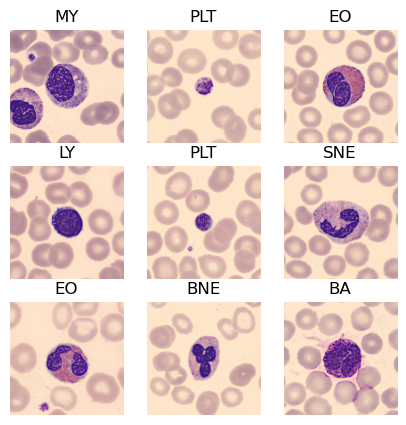

In [4]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(5, 5))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy())
  plt.title(class_names[np.argmax(label_batch[i])])
  plt.axis("off")

In [5]:
import keras
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras import backend as K
from keras.applications.vgg16 import VGG16

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
model.add(Dense(128,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='softmax')) # model.add(Dense(11 +1, activation='softmax')) ??

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 15,774,091
Trainable params: 1,059,403
N

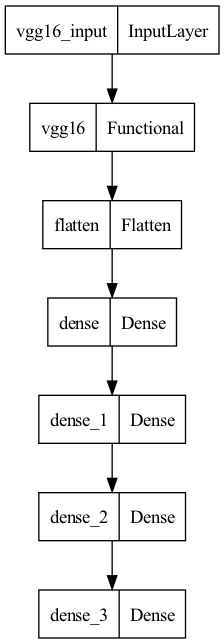

In [6]:
tf.keras.utils.plot_model(model)

In [22]:
epochs=50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             TensorBoard(log_dir=log_dir, histogram_freq=1)]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/50
338/338 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.5427

2023-04-26 22:47:45.347824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]
2023-04-26 22:47:45.348120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [3378]
	 [[{{node Placeholder/_4}}]]


338/338 [==============================] - 528s 2s/step - loss: 1.2811 - accuracy: 0.5427 - val_loss: 0.9166 - val_accuracy: 0.6699
Epoch 2/50
338/338 [==============================] - 522s 2s/step - loss: 0.8060 - accuracy: 0.7079 - val_loss: 0.8227 - val_accuracy: 0.7060
Epoch 3/50
338/338 [==============================] - 517s 2s/step - loss: 0.6685 - accuracy: 0.7550 - val_loss: 0.8592 - val_accuracy: 0.6901
Epoch 4/50
338/338 [==============================] - 514s 2s/step - loss: 0.5807 - accuracy: 0.7864 - val_loss: 0.8654 - val_accuracy: 0.6936
Epoch 5/50
338/338 [==============================] - 528s 2s/step - loss: 0.5185 - accuracy: 0.8116 - val_loss: 0.9117 - val_accuracy: 0.6945


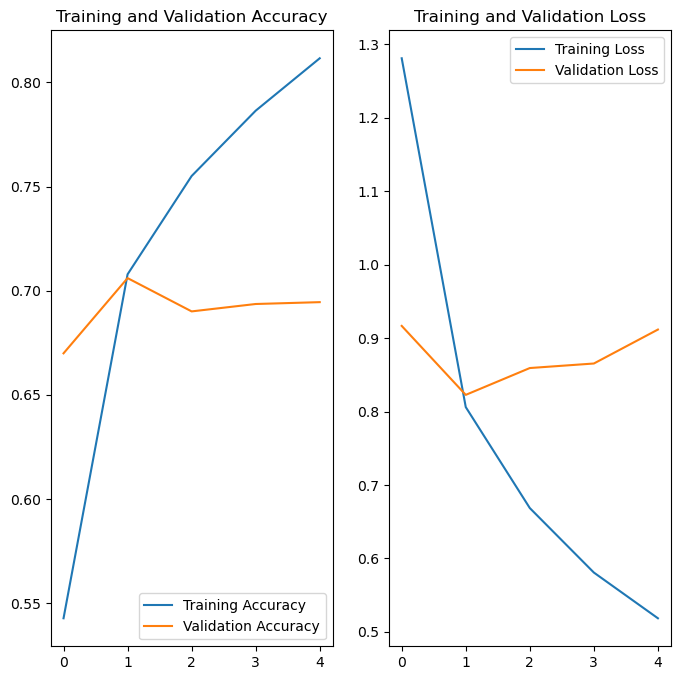

In [23]:
learning_curves(history)

In [24]:
model.save('../Models/VGG16_pt_11cat.h5')

In [25]:
VGG16 = tf.keras.models.load_model('../Models/VGG16_pt_11cat.h5')

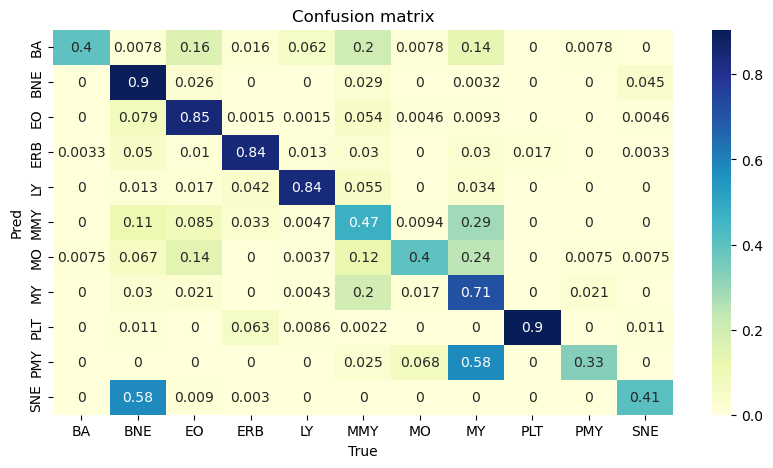

              precision    recall  f1-score   support

          BA       0.97      0.40      0.57       256
         BNE       0.47      0.90      0.62       312
          EO       0.82      0.85      0.83       647
         ERB       0.83      0.84      0.84       299
          LY       0.88      0.84      0.86       236
         MMY       0.33      0.47      0.39       212
          MO       0.85      0.40      0.54       268
          MY       0.40      0.71      0.51       235
         PLT       0.99      0.90      0.94       463
         PMY       0.81      0.33      0.47       118
         SNE       0.84      0.41      0.55       332

    accuracy                           0.69      3378
   macro avg       0.74      0.64      0.65      3378
weighted avg       0.77      0.69      0.70      3378



In [26]:
preds = VGG16.predict(
        val_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in val_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))

2023-04-26 23:28:14.241996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [2703,11]
	 [[{{node Placeholder/_1}}]]


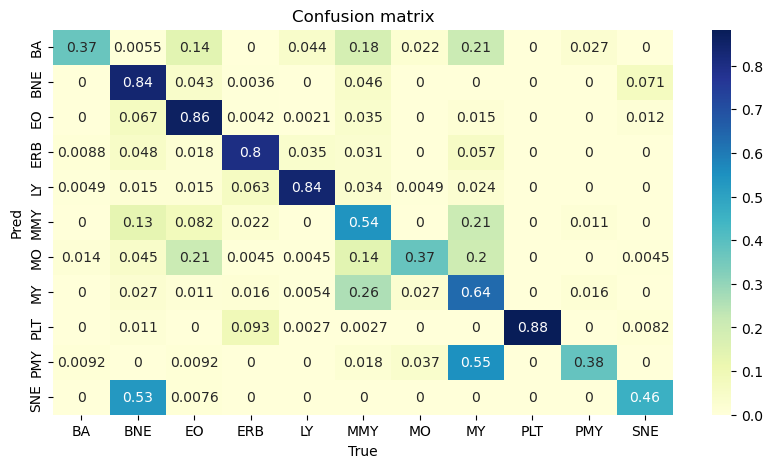

              precision    recall  f1-score   support

          BA       0.91      0.37      0.53       183
         BNE       0.51      0.84      0.63       281
          EO       0.79      0.86      0.83       481
         ERB       0.76      0.80      0.78       227
          LY       0.90      0.84      0.87       206
         MMY       0.38      0.54      0.45       182
          MO       0.86      0.37      0.52       222
          MY       0.36      0.64      0.46       184
         PLT       1.00      0.88      0.94       366
         PMY       0.80      0.38      0.51       109
         SNE       0.80      0.46      0.59       262

    accuracy                           0.69      2703
   macro avg       0.73      0.64      0.65      2703
weighted avg       0.75      0.69      0.69      2703



In [27]:
preds = VGG16.predict(
        test_ds,
        batch_size=32,
        verbose=0
)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
print(classification_report(true_labels,preds_labels))